# Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader

from tqdm import tqdm

# Model

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, ksize: int, stride: int, downsample=False):
        super().__init__()

        self.pad = ksize // 2
        self.downsample = downsample
        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channel, out_channels=out_channel, kernel_size=ksize, 
                stride=stride, padding=self.pad),
            nn.BatchNorm2d(out_channel),
            nn.ELU(inplace=True)
        )
        self.pool = nn.MaxPool2d((2, 2))

        self._init_weights(self.layers)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_normal_(module.weight.data, 0.0, 0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.xavier_normal_(module.weight.data, 1.0, 0.02)
            nn.init.constant_(module.bias.data, 0)


    def forward(self, x):
        out = self.layers(x)

        if self.downsample:
            out = self.pool(out)

        return out

class TransposeConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, upsample=False, ksize=None, stride=None):
        super().__init__()

        self.upsample = upsample
        self.stride = 2 if upsample else 1
        self.ksize = 4 if upsample else 3
        self.pad = 1

        if ksize:
            self.ksize = ksize
            self.pad = 0
        if stride:
            self.stride = stride

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channel, out_channels=out_channel,
                kernel_size=self.ksize, stride=self.stride, padding=self.pad
            ),
            nn.BatchNorm2d(out_channel),
            nn.ELU(inplace=True)
        )
        self._init_weights(self.layers)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_normal_(module.weight.data, 0.0, 0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.xavier_normal_(module.weight.data, 1.0, 0.02)
            nn.init.constant_(module.bias.data, 0)


    def forward(self, x):
        out = self.layers(x)

        return out

In [3]:
# channel of latent vector
z_dim = 100

In [4]:
class Discriminator(nn.Module):
    def __init__(self, hidden_c):
        super().__init__()
        # B x 1 x 28 x 28 -> B x 64 x 28 x 28
        self.input_layer = ConvBlock(in_channel=1, out_channel=hidden_c, ksize=5, stride=1)
        
        self.hidden_layers = nn.Sequential(
            # B x 64 x 28 x 28 -> B x 128 x 14 x 14
            ConvBlock(in_channel=1 * hidden_c, out_channel=2 * hidden_c, ksize=3, stride=1, downsample=True),
            # B x 128 x 14 x 14 -> B x 256 x 14 x 14 
            ConvBlock(in_channel=2 * hidden_c, out_channel=4 * hidden_c, ksize=3, stride=1),
            # B x 256 x 14 x 14 -> B x 512 x 7 x 7
            ConvBlock(in_channel=4 * hidden_c, out_channel=8 * hidden_c, ksize=3, stride=1, downsample=True),
        )
        self.output_layer = nn.Sequential(
            # B x 512 x 7 x 7 -> B x 100 x 7 x 7
            ConvBlock(in_channel=8 * hidden_c, out_channel=z_dim, ksize=1, stride=1),
            # B x 100 x 7 x 7 -> B x 100 x 1 x 1
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            # B x 100 x 1 x 1 -> B x 1
            nn.Linear(z_dim, 1),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        out = self.input_layer(x)
        out = self.hidden_layers(out)
        out = self.output_layer(out)

        return out
        

In [5]:
class Generator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.input_layer = nn.Sequential(
            # B x 100 x 1 x 1 -> B x 100 x 7 x 7 
            TransposeConvBlock(z_dim, z_dim, ksize=7, stride=1),
            # B x 100 x 7 x 7 -> B x 512 x 7 x 7
            TransposeConvBlock(z_dim, 8 * hidden_dim, upsample=False),
        )
        self.hidden_layers = nn.Sequential(
            # B x 512 x 7 x 7 -> B x 256 x 14 x 14
            TransposeConvBlock(8 * hidden_dim, 4 * hidden_dim, upsample=True),
            # B x 256 x 14 x 14 -> B x 128 x 14 x 14
            TransposeConvBlock(4 * hidden_dim, 2 * hidden_dim, upsample=False),
            # B x 128 x 14 x 14 -> B x 64 x 28 x 28
            TransposeConvBlock(2 * hidden_dim, 1 * hidden_dim, upsample=True),
        )
        self.output_layer = nn.Sequential(
            nn.Conv2d(hidden_dim, 1, kernel_size=1),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.input_layer(x)
        out = self.hidden_layers(out)
        out = self.output_layer(out)

        return out

# Dataset

In [6]:
BATCH_SIZE = 64


dataset = dset.MNIST(
    root="./data/",
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    download=True
)


data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=8,
    shuffle=True,
    drop_last=True
)

# Train

In [7]:
G = Generator(64).to("cuda")
D = Discriminator(64).to("cuda") 

criterion = nn.BCELoss().cuda()
D_optimizer = optim.Adam(params=D.parameters(), lr=2e-4)
G_optimizer = optim.Adam(params=G.parameters(), lr=2e-4)

K = 1
epochs = 100

In [11]:
total_batch = len(data_loader)
img_list = []

for epoch in range(epochs):
    avgLoss_D_real = 0
    avgLoss_D_fake = 0
    avgLoss_G = 0

    for X, Y in tqdm(data_loader):
        X = X.cuda()

        for _ in range(K):
            noise = torch.randn(BATCH_SIZE, z_dim, device="cuda")
            noise = noise.view(BATCH_SIZE, z_dim, 1, 1)
            fake = G(noise)

            predict = D(X).view(-1)

            real_label = torch.ones((BATCH_SIZE,), dtype=torch.float, device="cuda")
            lossD_real = criterion(predict, real_label.detach())    

            predict = D(fake.detach()).view(-1)

            fake_label = torch.zeros((BATCH_SIZE,), dtype=torch.float, device="cuda")
            lossD_fake = criterion(predict, fake_label.detach())

            lossD = (lossD_real + lossD_fake) / 2

            D.zero_grad()
            lossD.backward()
            D_optimizer.step()

        noise = torch.randn(BATCH_SIZE, z_dim, device="cuda")
        noise = noise.view(BATCH_SIZE, z_dim, 1, 1)
        fake = G(noise)
        real_label_G = torch.zeros((BATCH_SIZE,), dtype=torch.float, device="cuda")

        predict = D(fake).view(-1)
        lossG = criterion(1 - predict, real_label_G.detach())

        G.zero_grad()
        lossG.backward()
        G_optimizer.step()

        avgLoss_D_real += lossD_real.mean().item() / total_batch
        avgLoss_D_fake += lossD_fake.mean().item() / total_batch
        avgLoss_G += lossG.mean().item() / total_batch
    
        if (epoch+1) % 1 == 0:
            print(f"epoch: {epoch+1:3d}\tloss D real: {avgLoss_D_real:.5f}\tloss D fake: {avgLoss_D_fake:.5f}\tloss G: {avgLoss_G:.5f}")
            img_list.append(fake)



  0%|          | 3/937 [00:00<02:25,  6.44it/s]

epoch:   1	loss D real: 0.00020	loss D fake: 0.00007	loss G: 0.00344
epoch:   1	loss D real: 0.00040	loss D fake: 0.00014	loss G: 0.00685
epoch:   1	loss D real: 0.00067	loss D fake: 0.00020	loss G: 0.00948


  1%|          | 5/937 [00:00<01:47,  8.66it/s]

epoch:   1	loss D real: 0.00071	loss D fake: 0.00037	loss G: 0.01137
epoch:   1	loss D real: 0.00077	loss D fake: 0.00063	loss G: 0.01344
epoch:   1	loss D real: 0.00082	loss D fake: 0.00104	loss G: 0.01646


  1%|          | 9/937 [00:00<01:24, 10.96it/s]

epoch:   1	loss D real: 0.00106	loss D fake: 0.00110	loss G: 0.01926
epoch:   1	loss D real: 0.00138	loss D fake: 0.00119	loss G: 0.02224
epoch:   1	loss D real: 0.00173	loss D fake: 0.00127	loss G: 0.02435


  1%|          | 11/937 [00:01<01:19, 11.67it/s]

epoch:   1	loss D real: 0.00180	loss D fake: 0.00171	loss G: 0.02599
epoch:   1	loss D real: 0.00201	loss D fake: 0.00193	loss G: 0.02737
epoch:   1	loss D real: 0.00208	loss D fake: 0.00209	loss G: 0.02911


  2%|▏         | 15/937 [00:01<01:13, 12.53it/s]

epoch:   1	loss D real: 0.00216	loss D fake: 0.00225	loss G: 0.03187
epoch:   1	loss D real: 0.00226	loss D fake: 0.00240	loss G: 0.03475
epoch:   1	loss D real: 0.00257	loss D fake: 0.00249	loss G: 0.03692


  2%|▏         | 17/937 [00:01<01:12, 12.74it/s]

epoch:   1	loss D real: 0.00270	loss D fake: 0.00262	loss G: 0.03949
epoch:   1	loss D real: 0.00282	loss D fake: 0.00286	loss G: 0.04196
epoch:   1	loss D real: 0.00299	loss D fake: 0.00303	loss G: 0.04432


  2%|▏         | 21/937 [00:01<01:10, 12.98it/s]

epoch:   1	loss D real: 0.00308	loss D fake: 0.00314	loss G: 0.04749
epoch:   1	loss D real: 0.00327	loss D fake: 0.00321	loss G: 0.04987
epoch:   1	loss D real: 0.00345	loss D fake: 0.00333	loss G: 0.05235


  2%|▏         | 23/937 [00:02<01:10, 13.04it/s]

epoch:   1	loss D real: 0.00353	loss D fake: 0.00356	loss G: 0.05400
epoch:   1	loss D real: 0.00377	loss D fake: 0.00365	loss G: 0.05582
epoch:   1	loss D real: 0.00388	loss D fake: 0.00402	loss G: 0.05894


  3%|▎         | 27/937 [00:02<01:09, 13.12it/s]

epoch:   1	loss D real: 0.00405	loss D fake: 0.00431	loss G: 0.06248
epoch:   1	loss D real: 0.00489	loss D fake: 0.00437	loss G: 0.06472
epoch:   1	loss D real: 0.00562	loss D fake: 0.00461	loss G: 0.06515


  3%|▎         | 29/937 [00:02<01:09, 13.14it/s]

epoch:   1	loss D real: 0.00566	loss D fake: 0.00553	loss G: 0.06679
epoch:   1	loss D real: 0.00576	loss D fake: 0.00616	loss G: 0.06965
epoch:   1	loss D real: 0.00603	loss D fake: 0.00627	loss G: 0.07332


  4%|▎         | 33/937 [00:02<01:08, 13.18it/s]

epoch:   1	loss D real: 0.00657	loss D fake: 0.00631	loss G: 0.07671
epoch:   1	loss D real: 0.00772	loss D fake: 0.00635	loss G: 0.07864
epoch:   1	loss D real: 0.00780	loss D fake: 0.00664	loss G: 0.07931


  4%|▎         | 35/937 [00:02<01:08, 13.19it/s]

epoch:   1	loss D real: 0.00789	loss D fake: 0.00743	loss G: 0.07998
epoch:   1	loss D real: 0.00792	loss D fake: 0.00831	loss G: 0.08176
epoch:   1	loss D real: 0.00807	loss D fake: 0.00865	loss G: 0.08445


  4%|▍         | 39/937 [00:03<01:07, 13.21it/s]

epoch:   1	loss D real: 0.00834	loss D fake: 0.00875	loss G: 0.08794
epoch:   1	loss D real: 0.00894	loss D fake: 0.00880	loss G: 0.09149
epoch:   1	loss D real: 0.00960	loss D fake: 0.00883	loss G: 0.09431


  4%|▍         | 41/937 [00:03<01:07, 13.22it/s]

epoch:   1	loss D real: 0.00972	loss D fake: 0.00892	loss G: 0.09686
epoch:   1	loss D real: 0.00980	loss D fake: 0.00912	loss G: 0.09878
epoch:   1	loss D real: 0.00987	loss D fake: 0.00942	loss G: 0.10010


  5%|▍         | 45/937 [00:03<01:07, 13.20it/s]

epoch:   1	loss D real: 0.00991	loss D fake: 0.00991	loss G: 0.10253
epoch:   1	loss D real: 0.01001	loss D fake: 0.01008	loss G: 0.10583
epoch:   1	loss D real: 0.01016	loss D fake: 0.01019	loss G: 0.10967


  5%|▌         | 47/937 [00:03<01:07, 13.19it/s]

epoch:   1	loss D real: 0.01036	loss D fake: 0.01023	loss G: 0.11308
epoch:   1	loss D real: 0.01069	loss D fake: 0.01029	loss G: 0.11602
epoch:   1	loss D real: 0.01087	loss D fake: 0.01036	loss G: 0.11843


  5%|▌         | 51/937 [00:04<01:07, 13.21it/s]

epoch:   1	loss D real: 0.01114	loss D fake: 0.01050	loss G: 0.12026
epoch:   1	loss D real: 0.01130	loss D fake: 0.01084	loss G: 0.12193
epoch:   1	loss D real: 0.01142	loss D fake: 0.01127	loss G: 0.12380


  6%|▌         | 53/937 [00:04<01:06, 13.20it/s]

epoch:   1	loss D real: 0.01149	loss D fake: 0.01167	loss G: 0.12690
epoch:   1	loss D real: 0.01183	loss D fake: 0.01187	loss G: 0.12941
epoch:   1	loss D real: 0.01237	loss D fake: 0.01198	loss G: 0.13199


  6%|▌         | 57/937 [00:04<01:06, 13.21it/s]

epoch:   1	loss D real: 0.01257	loss D fake: 0.01209	loss G: 0.13358
epoch:   1	loss D real: 0.01268	loss D fake: 0.01232	loss G: 0.13559
epoch:   1	loss D real: 0.01273	loss D fake: 0.01274	loss G: 0.13833


  6%|▋         | 59/937 [00:04<01:06, 13.20it/s]

epoch:   1	loss D real: 0.01285	loss D fake: 0.01291	loss G: 0.14175
epoch:   1	loss D real: 0.01302	loss D fake: 0.01299	loss G: 0.14463
epoch:   1	loss D real: 0.01330	loss D fake: 0.01303	loss G: 0.14824


  7%|▋         | 63/937 [00:05<01:06, 13.19it/s]

epoch:   1	loss D real: 0.01338	loss D fake: 0.01308	loss G: 0.15117
epoch:   1	loss D real: 0.01364	loss D fake: 0.01319	loss G: 0.15370
epoch:   1	loss D real: 0.01377	loss D fake: 0.01329	loss G: 0.15552


  7%|▋         | 65/937 [00:05<01:06, 13.16it/s]

epoch:   1	loss D real: 0.01382	loss D fake: 0.01354	loss G: 0.15703
epoch:   1	loss D real: 0.01385	loss D fake: 0.01374	loss G: 0.15984
epoch:   1	loss D real: 0.01390	loss D fake: 0.01389	loss G: 0.16236


  7%|▋         | 69/937 [00:05<01:05, 13.16it/s]

epoch:   1	loss D real: 0.01404	loss D fake: 0.01394	loss G: 0.16553
epoch:   1	loss D real: 0.01425	loss D fake: 0.01405	loss G: 0.16923
epoch:   1	loss D real: 0.01437	loss D fake: 0.01412	loss G: 0.17173


  8%|▊         | 71/937 [00:05<01:05, 13.18it/s]

epoch:   1	loss D real: 0.01444	loss D fake: 0.01418	loss G: 0.17519
epoch:   1	loss D real: 0.01473	loss D fake: 0.01424	loss G: 0.17642


  8%|▊         | 71/937 [00:05<01:11, 12.18it/s]


KeyboardInterrupt: 

# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

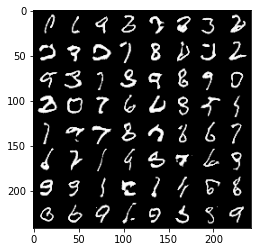

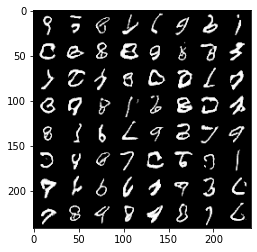

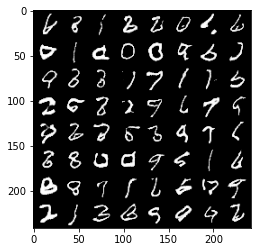

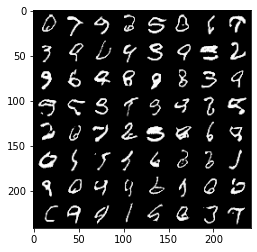

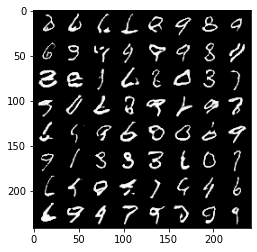

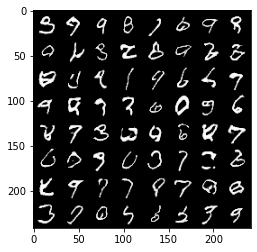

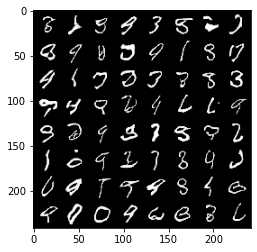

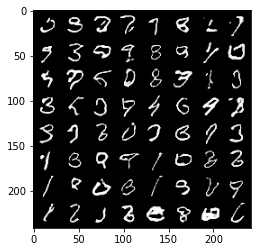

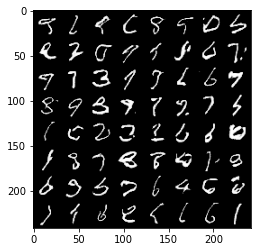

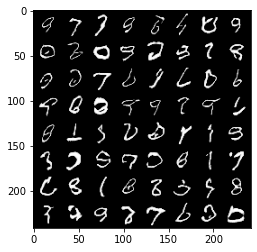

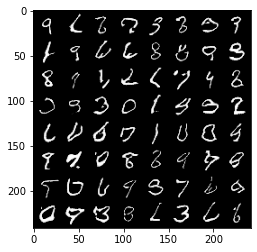

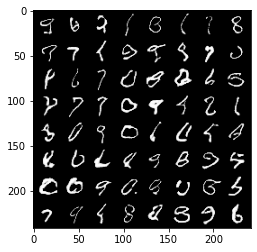

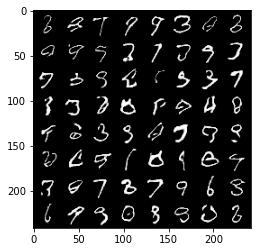

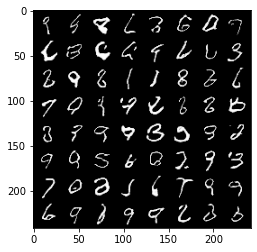

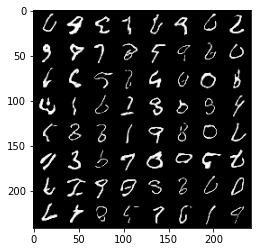

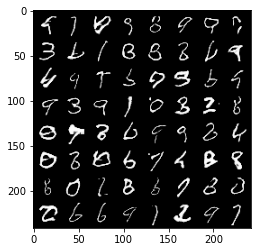

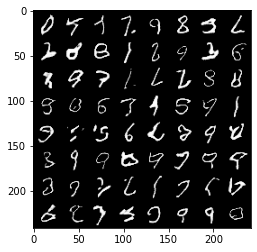

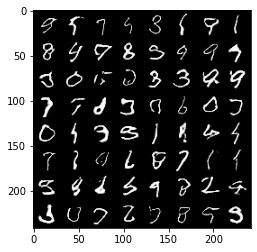

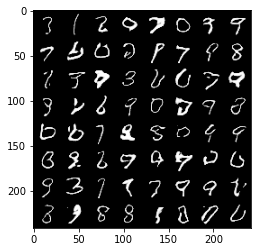

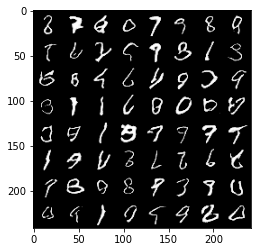

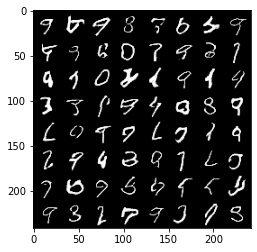

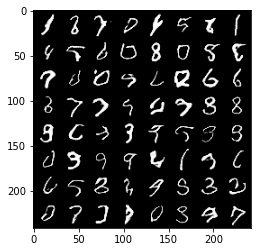

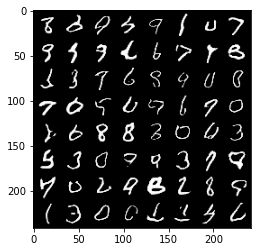

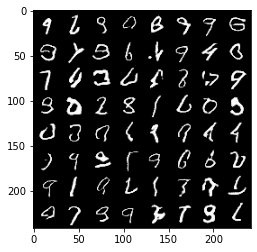

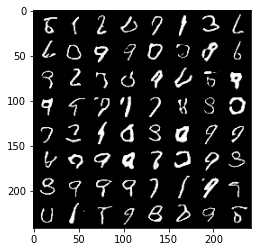

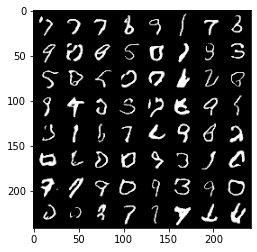

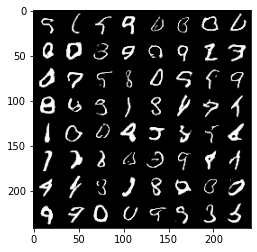

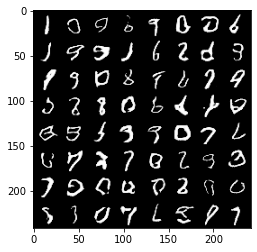

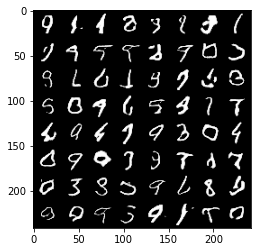

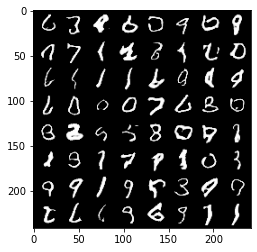

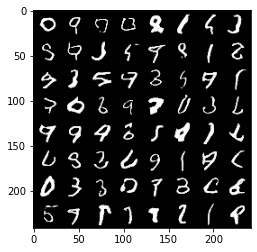

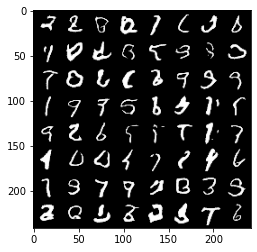

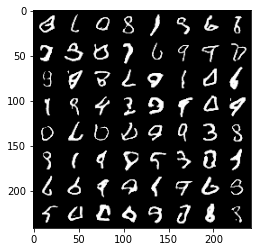

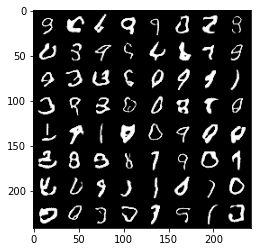

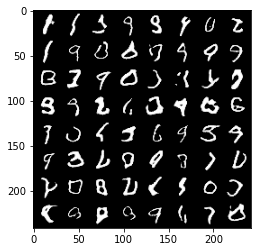

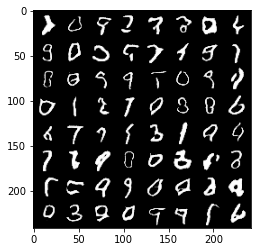

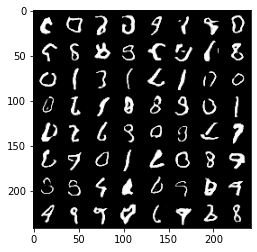

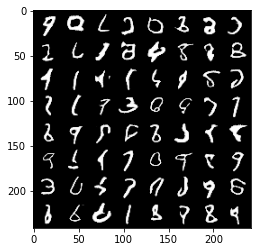

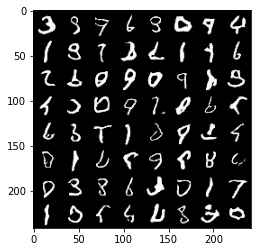

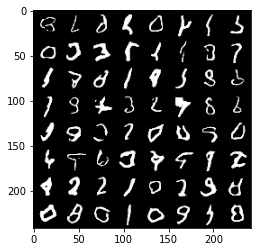

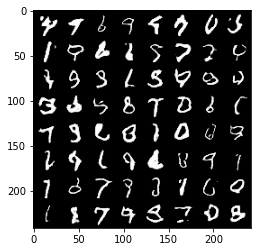

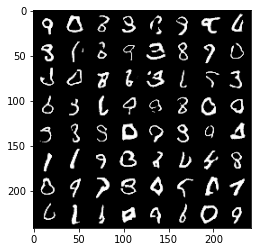

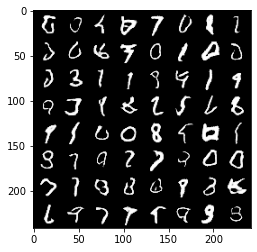

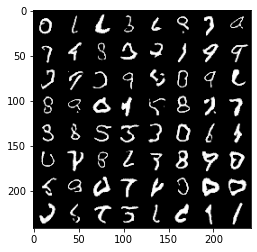

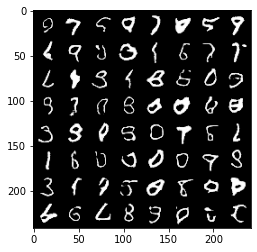

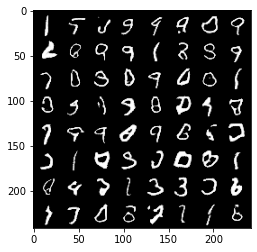

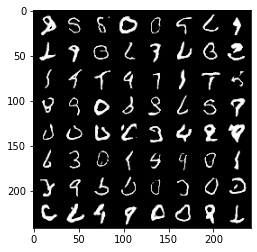

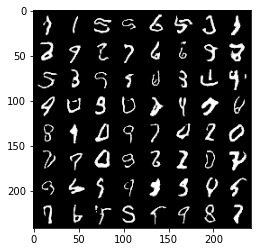

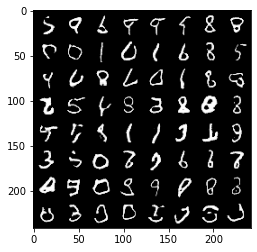

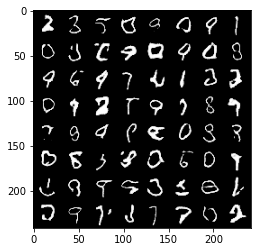

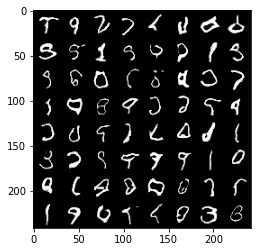

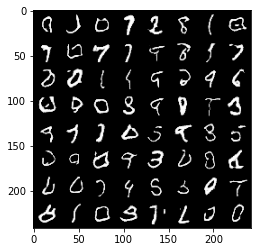

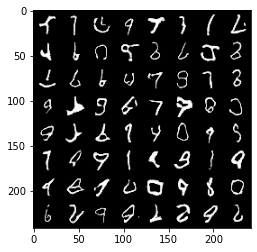

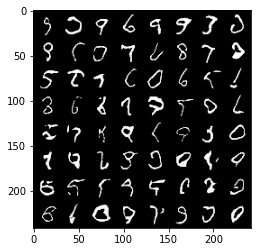

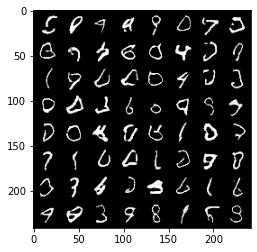

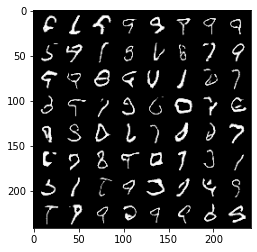

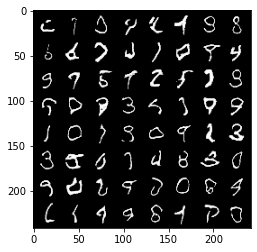

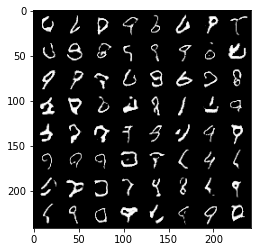

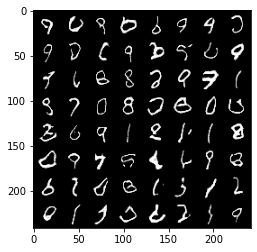

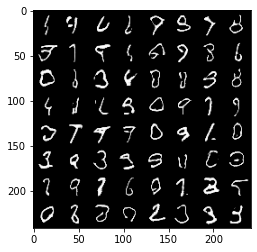

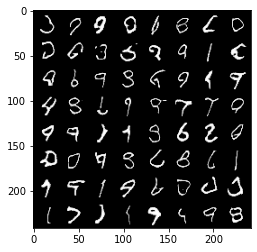

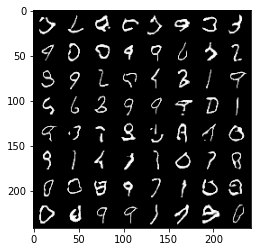

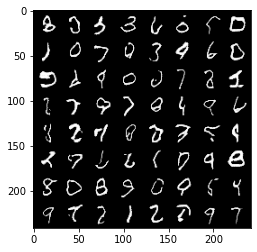

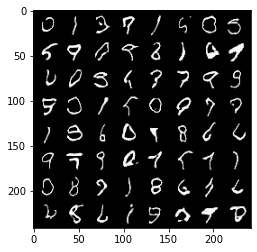

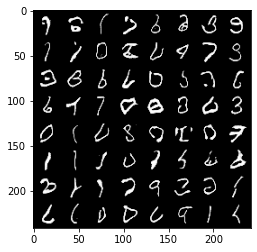

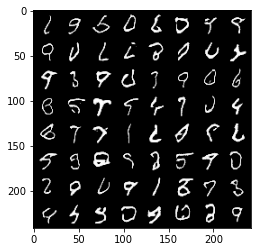

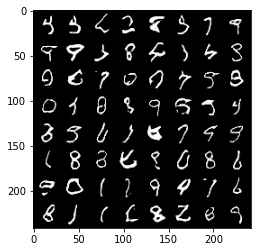

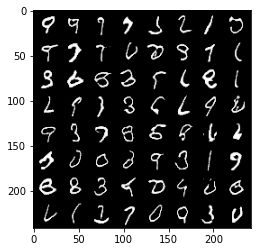

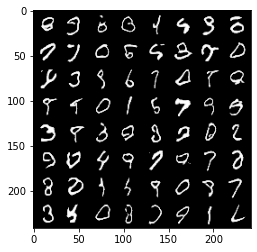

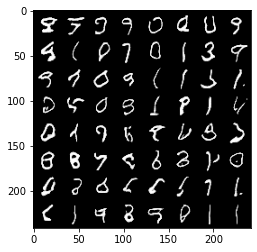

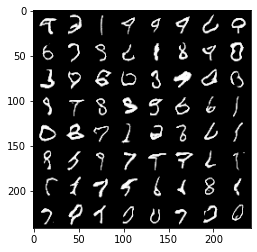

: 

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

for i, img in enumerate(img_list):
    img = torchvision.utils.make_grid(img)
    img = img.detach().cpu().numpy()
    img = img.transpose((1, 2, 0))
    # img = img.reshape(28, 28)
    plt.figure(i)
    plt.imshow(img)
